# Criação do bot

# Primeiro Passo, Aquisição dos dados

# Candles

Candlestick ou gráfico de candles é um tipo de notação criada por Japoneses no século XVIII onde eles faziam muitas negociações com arroz, como compra venda e contratos futuros.

Desde então essa notação foi amplamente utilizada por traders pois mostram muitas informações esseiciais sobre o estado do preço de um ativo.

### Elementos de um CandleStick

+ ***Período***: O período representa o que ocorreu com o preço de uma ação em um período de tempo, cada candle pode representar 1 minuto, 5 minutos, uma hora, um mês e até um ano. 
+ ***Formato***: O formato do candle representa valores importantes que o preço da ação atingiu em um determinado período de tempo. O modelo OHLC representa
    * Abertura: valor no momento inicial do candle
    * Máximo: valor máximo do ativo no período 
    * Mínimo: valor mínimo do ativo no período
    * Fechamento: Valor ao fim do período
+ ***Cor***: A cor determina se o candle é de alta ou de baixa 
    * Quando o preço de fechamento for maior que o preço de abertura, significa que o preço subiu durante aquele período e o candlestick será de alta.
    * Quando o preço de fechamento está abaixo do preço de abertura, significa que o preço da ação caiu durante aquele determinado período, e o Candle será de baixa.


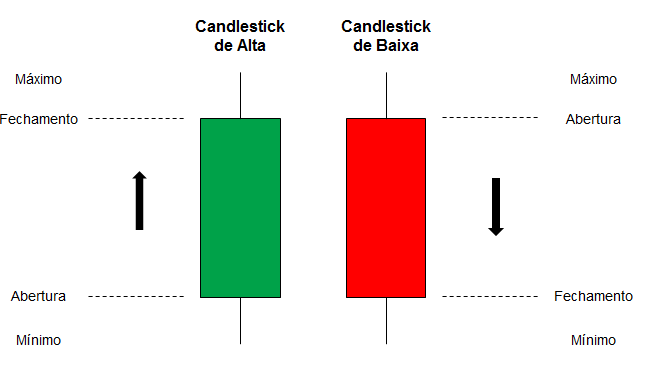

# Pegando os Candles da API

In [26]:
import requests, json
from binance.client import Client
from binance.enums import *

import pandas as pd
import numpy as np

import time
from datetime import datetime

from math import pi
from bokeh.plotting import figure, show, output_file
from bokeh.sampledata.stocks import MSFT
from bokeh.models import Band
%matplotlib inline


from pyti.exponential_moving_average import exponential_moving_average as ema
from pyti.aroon import aroon_down, aroon_up
from pyti.ichimoku_cloud import tenkansen, kijunsen, chiku_span, senkou_a, senkou_b
from pyti.momentum import momentum

import matplotlib.pyplot as plt
import seaborn as sns


class Aquisition(object):
    def __init__(self):
        self.client = Client('', '')
        self.df = ""
        
    def getCandles(self):
        self.df = pd.DataFrame(columns= ['Open_time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close_time'])
        candles = self.client.get_klines(symbol='BTCUSDT', interval=Client.KLINE_INTERVAL_5MINUTE)

        opentime, lopen, lhigh, llow, lclose, lvol, closetime = [], [], [], [], [], [], []

        for candle in candles:
            opentime.append(candle[0])
            lopen.append(candle[1])
            lhigh.append(candle[2])
            llow.append(candle[3])
            lclose.append(candle[4])
            lvol.append(candle[5])
            closetime.append(candle[6])

        self.df['Open_time'] = opentime
        self.df["date"] = opentime
        self.df['Open'] = np.array(lopen).astype(np.float)
        self.df['High'] = np.array(lhigh).astype(np.float)
        self.df['Low'] = np.array(llow).astype(np.float)
        self.df['Close'] = np.array(lclose).astype(np.float)
        self.df['Volume'] = np.array(lvol).astype(np.float)
        self.df['Close_time'] = closetime
        self.df["date"] = pd.to_datetime(self.df['date'],unit='ms')
        return self.df
    
    def getPriceNow(self):
        r = requests.get(
            "https://www.binance.com/api/v3/ticker/price?symbol=BTCUSDT")
        r = r.content
        jsonResponse = json.loads(r.decode('utf-8'))
        return float(jsonResponse['price'])
    
    def plotCandles(self):
        df = self.df[450:]
        df["date"] = df["Open_time"]
        df["date"] = pd.to_datetime(self.df['date'],unit='ms')

        inc = df.Close > df.Open
        dec = df.Open > df.Close
        w = 12*60*60*1000 # half day in ms

        TOOLS = "pan,wheel_zoom,box_zoom,reset,save"

        p = figure(x_axis_type="datetime", tools=TOOLS, plot_width=1000, title = "BITCOIN Candlestick")
        p.xaxis.major_label_orientation = pi/4
        p.grid.grid_line_alpha=0.3

        p.segment(df.date, df.High, df.date, df.Low, color="black")
        p.vbar(df.date[inc], w, df.Open[inc], df.Close[inc], fill_color="#006400", line_color="black")
        p.vbar(df.date[dec], w, df.Open[dec], df.Close[dec], fill_color="#F2583E", line_color="black")

        output_file("candlestick.html", title="candlestick.py Grafico de Candles")

        show(p)  

# Criando Criando indicadores

### O que são indicadores 

Day traders tomam decisões a partir de gráficos, cada trader usa uma técnica diferente, porém suas estratégiassão agrupadas em algumas categorias. Indicadores são nada mais do quê estratégias estatísticas para mostrar o comportamendo do mercado em determinado período. Geralmente indicadores pretendem mostrar fluxo de ordens, sazonalidade tendências e etc.

Muitos tradders iniciantes se amarram a alguns indicadores crendo que funcionam sempre, o que se caracteriza em um erro grave pois existem inúmeros indicadores que devem ser usados em diferentes momentos. 


Exemplos de indicadores:

***Bandas de Boillinger***

![image.png](https://www.oanda.com/wandacache/2017_bollingerbandsformula-91337ad4d173ccef8e6057242e2188e2fbfc28d2.png)

***RSI***

![image.png](https://www.disnat.com/Content/images/BrokerageNotion/technical-analysis12e.jpg)



## Calculando indicadores

***Bandas de boillinger*** 

In [27]:
class Bbands(Aquisition):  
    
    def __init__(self, nDer = 2, period = 20):
        super(Bbands, self).__init__()
        self.candles = super().getCandles()
        self.nDer = nDer
        self.period = period
    
    def calcBands(self):
        self.candles['30 Day MA'] = self.candles['Close'].rolling(window=self.period).mean()
        self.candles['30 Day STD'] = self.candles['Close'].rolling(window=self.period).std()
        self.candles['Upper Band'] = self.candles['30 Day MA'] + (self.candles['30 Day STD'] * self.nDer)
        self.candles['Lower Band'] = self.candles['30 Day MA'] - (self.candles['30 Day STD'] * self.nDer)
        
    def plotSetting(self, df):
        TOOLS = "pan,wheel_zoom,box_zoom,reset,save"
        p = figure(x_axis_type="datetime", tools=TOOLS, plot_width=1000, title = "Bbands Chart")
        p.xaxis.major_label_orientation = pi/4
        p.grid.grid_line_alpha=0.3
        p.line(df.date, df.Close, line_color="black")
        p.line(df.date, df['30 Day MA'], line_color="red", legend="30 Day MA", muted_alpha=0.2)
        p.line(df.date, df['Upper Band'], line_color="blue", legend="Upper Band", muted_alpha=0.2)
        p.line(df.date, df['Lower Band'], line_color="green", legend="Lower Band", muted_alpha=0.2)
        
        p.legend.location = "top_left"
        p.legend.click_policy="mute"
        return p
        
    def plotBands(self):
        df = self.candles
        p = self.plotSetting(df)
        output_file("candlestick.html", title="candlestick.py Bbands")
        show(p)  
        
    def detectCross(self):
        self.calcBands()
        #self.candles['up_cross'] = np.where((self.candles['Close'] >= self.candles['Upper Band'])
        #             , self.candles['Close'], '')
        
        self.candles['up_cross'] = np.where((self.candles['Close'] >= self.candles['Upper Band'])
             , 1, 0)
        
        #self.candles['down_cross'] = np.where((self.candles['Close'] <= self.candles['Lower Band'])
         #    , self.candles['Close'],  '')
        
        self.candles['down_cross'] = np.where((self.candles['Close'] <= self.candles['Lower Band'])
             , 1,  0)
        
        p = self.plotSetting(self.candles)        
        p.circle(self.candles.date, self.candles['up_cross'], size=5, color="red", alpha=1)
        p.circle(self.candles.date, self.candles['down_cross'], size=5, color="green", alpha=1)
        
        output_file("candlestick.html", title="candlestick.py Bbands")
        show(p)  
        
    def generateSignal(self):
        aq = Aquisition()
        self.candles = aq.getCandles()
        
        ma = self.candles['Close'][480:].mean()
        sma = self.candles['Close'][480:].std()
        ub = ma + (sma * 2)
        lb = ma - (sma * 2)
        print(type(ub))
        price  = aq.getPriceNow()
        
        if(price < lb):
            return 'buy'
        
        if(price > ub):
            return 'sell'
        
        else:
            return 'hold'

# Analizando Correlação

In [28]:
class Corr(object):
    def __init__(self, df):
        self.df = df
        try:
            self.df = self.df.drop(['High', 'Low', 'Open'], axis=1)
        except:
            pass
    
    def pearson(self):
        plt.figure(figsize=(12,8))
        kwargs = {'fontsize':12,'color':'black'}
        sns.heatmap(self.df.corr(),annot=True,robust=True)
        plt.title('Correlation Analysis',**kwargs)
        plt.tick_params(length=3,labelsize=12,color='black')
        plt.yticks(rotation=0)
        plt.show()

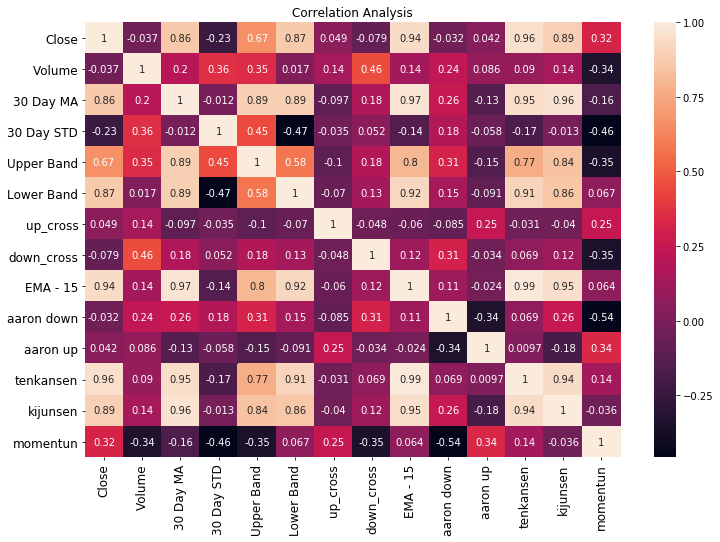

CPU times: user 645 ms, sys: 15.7 ms, total: 660 ms
Wall time: 671 ms


In [30]:
%%time

c = Corr(candles)
c.pearson()

# MEEEEEEEEEEEEEEEEEEH Não ajudou porra nenhuma


# Criando variável target

#### Ta bem bosta mas vou pensar uma parada mais elaborada 

# METODO LOOCKAHEAD 10 CANDLES 

### Aqui eh o seguinte, ***Eu olho 10 candles a frente e vejo se o preço subiu ou desceu, se subiu eu compro no passado e se desceu eu vendo no passado***

In [31]:
class Target(object):
    def __init__(self, candles):
        self.candles = candles
        self.buy = [] 
        self.sell = []
        self.hold = []
        self.close = self.candles['Close'].tolist() 
        
        
    def fill(self, vBuy, vSell):
        self.buy.append(vBuy) 
        self.sell.append(vSell)
        
    def testTarget(self):
        for i in range (0, len(self.close)-11):
            if float(self.close[i]) < float(self.close[i+10]):
                self.fill(self.close[i], 'NaN')
            elif float(self.close[i]) > float(self.close[i+10]):
                self.fill('NaN', self.close[i])
                
        for i in range (488, 500):
            self.fill('NaN', 'NaN')
            
        self.candles['buy'] = self.buy
        self.candles['sell'] = self.sell
        
    def plotTargets(self):   
        TOOLS = "pan,wheel_zoom,box_zoom,reset,save"
        p = figure(x_axis_type="datetime", tools=TOOLS, plot_width=1000, title = "Bbands Chart")
        p.xaxis.major_label_orientation = pi/4
        p.grid.grid_line_alpha=0.3

        p.line(self.candles.date, self.candles.Close, line_color="black")

        p.circle(self.candles.date, self.candles['sell'], size=5, color="red", alpha=1, legend='buy')
        p.circle(self.candles.date, self.candles['buy'], size=5, color="green", alpha=1, legend='sell')

        output_file("candlestick.html", title="candlestick.py Bbands")
        show(p)  

# Ver a cagada

In [32]:
def createTarget(candles):
    
    close = candles['Close'].tolist()
    target = []
    
    for i in range (0, len(close)-11):
        if float(close[i]) < float(close[i+10]):
            target.append(0)

        elif float(close[i]) > float(close[i+10]):
            target.append(1)
            
    for i in range (488, 500):
        target.append('NaN')
        
    candles['target'] = target

# Decision Tree


### Apagar as linhas NaN e ver o que sobra


In [33]:
class cleanData(object):
    def __init__(self, candles):
        self.candles = candles

    def clean(self):
        try:
            self.candles = self.candles.drop(['sell', 'buy'], axis=1)
        except:
            print('Erro apagando sell e buy')
            pass
        
        self.candles = self.candles.dropna()
        for column in self.candles:
            self.candles = self.candles[~self.candles[column].isin(['NaN'])]

        self.candles.to_csv('csv_ok', sep=',', encoding='utf-8')
        return self.candles

# Criar sinal com decision 

In [34]:
import io
from scipy import misc
from sklearn import tree # pack age tree 
from sklearn.metrics import accuracy_score # medir % acerto
from sklearn.model_selection import train_test_split # cortar dataset
from sklearn.tree import DecisionTreeClassifier, export_graphviz # arvore de decixao classificacao e graphviz para visualizar
import pydotplus

class Dct(object):
    def __init__(self, candles):
        self.candles = candles
        self.train = None
        self.test = None
        self.tree = None
        self.features = []
        self.xtrain = None
        self.ytrain = None
        self.xtest = None
        self.ytest = None
        self.fitted = None

    def split(self):
        self.train, self.test = train_test_split(self.candles, test_size=round(len(self.candles)*0.2))
    
    def castTarget(self):
        self.train['target'] = pd.to_numeric(self.train['target'], downcast='float')
        self.test['target'] = pd.to_numeric(self.test['target'], downcast='float')
        
    def createTree(self):
        self.tree = DecisionTreeClassifier(min_samples_split=100)
    
    def createFeatures(self):
        self.features = ['Open', 'High', 'Low', 'Close', 'Volume', '30 Day MA',
                   '30 Day STD', 'Upper Band', 'Lower Band', #'up_cross', 'down_cross',
                   'EMA - 15', 'aaron down', 'aaron up', 'tenkansen', 'kijunsen',
                   'momentun']
        
    def mount(self):
        self.x_train = self.train[self.features]
        self.y_train = self.train['target']
        self.x_test = self.test[self.features]
        self.y_test = self.test['target']
        
    def fitTree(self):
        self.fitted = self.tree.fit(self.x_train, self.y_train) 
        
    def showTree(self):
        file=io.StringIO()
        export_graphviz(self.tree, out_file=file, feature_names=self.features)
        pydotplus.graph_from_dot_data(file.getvalue()).write_png('dct.png')
        img = misc.imread('dct.png')
        plt.rcParams["figure.figsize"] = (20, 20)
        plt.imshow(img)
        
    def getPrediction(self):
        self.y_pred = self.fitted.predict(self.x_test)
        return accuracy_score(self.y_test, self.y_pred)*100
        
    def makePrediction(self, state):
        return self.fitted.predict(state)
        
    def getTree(self):
        self.split()
        self.castTarget()
        self.createTree()
        self.createFeatures()
        self.mount()
        self.fitTree()
        self.showTree()
        
    def createSignal(self):
        self.getTree()
        acc = self.getPrediction()
        state = self.candles.tail(1)
        state = state.drop(['target', 'date'], axis=1)
        pred = dct.makePrediction(state)
        state.head()
        if pred == 0:
            return 'buy', acc
        else: 
            return 'sell', acc

In [35]:
bb = Bbands()
bb.calcBands()
#bb.plotBands()
bb.detectCross()

#adicionando os outros indicadores
candles = bb.candles
candles = candles.drop(['Open_time', 'Close_time'], axis=1)
candles['EMA - 15'] = ema(candles['Close'].tolist(), 15)
candles['aaron down'] = aroon_down(candles['Close'].tolist(), 25)
candles['aaron up'] = aroon_up(candles['Close'].tolist(), 25)
candles['tenkansen'] = tenkansen(candles['Close'].tolist())
candles['kijunsen'] = kijunsen(candles['Close'].tolist())
candles['momentun'] = momentum(candles['Close'], 15)

#Definindo o target
t = Target(candles) 
#t.testTarget()
#t.plotTargets()
createTarget(t.candles)

#Limpando o dataframe
dt = cleanData(t.candles)
candles_no_NaN = dt.clean()
candles_no_NaN.tail()


Erro apagando sell e buy


,Open,High,Low,Close,Volume,date,30 Day MA,30 Day STD,Upper Band,Lower Band,up_cross,down_cross,EMA - 15,aaron down,aaron up,tenkansen,kijunsen,momentun,target
483,3581.71,3583.09,3581.14,3581.85,27.292239,2019-01-16 23:10:00,3582.1370,1.548993,3585.234986,3579.039014,0,0,3581.695428,44.0,8.0,3581.945,3582.990,3.23,0
484,3581.85,3583.53,3581.01,3583.47,43.178227,2019-01-16 23:15:00,3582.0705,1.454306,3584.979111,3579.161889,0,0,3582.011813,40.0,4.0,3581.945,3582.990,0.61,0
485,3582.47,3584.99,3582.06,3584.20,23.338651,2019-01-16 23:20:00,3582.1910,1.527826,3585.246652,3579.135348,0,0,3582.311463,36.0,4.0,3582.045,3582.990,0.55,0
486,3584.51,3591.99,3584.12,3590.88,58.427437,2019-01-16 23:25:00,3582.6035,2.473583,3587.550666,3577.656334,1,0,3583.523498,32.0,100.0,3585.385,3584.750,9.64,0
487,3590.88,3593.55,3588.06,3591.01,56.582318,2019-01-16 23:30:00,3582.9805,3.106271,3589.193042,3576.767958,1,0,3584.649802,28.0,100.0,3585.450,3584.815,9.51,1


In [123]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

train, test = train_test_split(candles_no_NaN, test_size=round(len(candles_no_NaN)*0.2))

train['target'] = pd.to_numeric(train['target'], downcast='float')
test['target'] = pd.to_numeric(test['target'], downcast='float')

features = ['Open', 'High', 'Low', 'Close', 'Volume', '30 Day MA',
                   '30 Day STD', 'Upper Band', 'Lower Band', #'up_cross', 'down_cross',
                   'EMA - 15', 'aaron down', 'aaron up', 'tenkansen', 'kijunsen',
                   'momentun']


clf = RandomForestClassifier(n_estimators=100)
clf.fit(x_train, y_train)


x_train = train[features]
y_train = train['target']
x_test = test[features]
y_test = test['target']

f_ypred = clf.predict(x_test)
score = accuracy_score(y_test, f_ypred) * 100
print('Score da decision tree: {}'.format(score))

/home/gabs/anaconda3/envs/Tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/gabs/anaconda3/envs/Tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


Score da decision tree: 95.6989247311828


# Normalizando com prescaller

Configuraremos agora o pipeline para realizar a validação cruzada mais a frente simplesmente declarando o objeto de classe da seguinte forma: Criando um um pipeline de modelagem que primeiro transforma e normaliza os dados usando o StandardScaler() e depois se ajusta a um modelo usando um regressor de random forest.

In [134]:
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

scaler = preprocessing.StandardScaler().fit(x_train)
x_train.head()

,Open,High,Low,Close,Volume,30 Day MA,30 Day STD,Upper Band,Lower Band,EMA - 15,aaron down,aaron up,tenkansen,kijunsen,momentun
454,3572.10,3576.85,3572.08,3575.01,47.633808,3573.5090,5.030924,3583.570849,3563.447151,3573.608834,32.0,12.0,3573.230,3575.375,7.03
191,3548.58,3552.15,3546.25,3549.41,49.050781,3545.7985,4.558856,3554.916213,3536.680787,3548.296952,8.0,76.0,3550.810,3543.605,7.82
479,3580.63,3584.04,3577.45,3580.85,51.024534,3582.5700,1.986234,3586.542468,3578.597532,3581.982941,8.0,24.0,3582.310,3581.185,-0.94
67,3605.14,3606.13,3591.00,3600.63,183.579839,3610.8340,3.240969,3617.315937,3604.352063,3610.116964,100.0,76.0,3607.815,3606.525,-10.76
194,3548.36,3554.45,3547.31,3552.30,107.190273,3546.8810,3.996739,3554.874479,3538.887521,3548.640779,8.0,64.0,3548.135,3544.245,12.97


In [135]:
x_train_scaled = scaler.transform(x_train)
x_train_scaled.std()

1.0

In [136]:
#n_estimators=100 (número de nós) , n_jobs=-1 ( todo o processamento possível) , warm_start=True (mantém o aprendizado e reprocessa o modelo, melhorando-o)
pipeline = make_pipeline(preprocessing.StandardScaler(), RandomForestClassifier(n_estimators=200, n_jobs=-1, warm_start=True))
hyperparameters = { 'randomforestclassifier__max_features' : ['auto', 'sqrt', 'log2'],
                  'randomforestclassifier__max_depth': [None, 5, 3, 1]}

O GridSearchCV essencialmente realiza a validação cruzada em toda a “grade” (todas as permutações possíveis) dos hiperparâmetros. Ele leva em seu modelo (neste caso, estamos usando um pipeline de modelo), os hiperparâmetros que você deseja ajustar e o número de dobras a serem criadas.

In [137]:
%%time
clf = GridSearchCV(pipeline, hyperparameters, cv=10)
clf.fit(x_train_scaled, y_train)

CPU times: user 55.7 s, sys: 6.07 s, total: 1min 1s
Wall time: 1min 23s


In [138]:
print(clf.best_params_)

{'randomforestclassifier__max_depth': None, 'randomforestclassifier__max_features': 'auto'}


In [139]:
clf = RandomForestClassifier(n_estimators=200, n_jobs=-1, warm_start=True, max_depth=None, max_features='auto')
clf.fit(x_train_scaled, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0, warm_start=True)

In [140]:
f_ypred = clf.predict(x_test)
score = accuracy_score(y_test, f_ypred) * 100
print('Score da decision tree: {}'.format(score))

Score da decision tree: 47.31182795698925


# Pipelines 

In [165]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn import svm

pip_1 = Pipeline([
    ('scaler',StandardScaler()),
    ('clf', RandomForestClassifier())
])

pip_1.fit(x_train, y_train)
np.mean(cross_val_score(pip_1, x_train, y_train, cv=5))

0.789024311983216

In [166]:
pip_2 = Pipeline([
    ('min_max_scaler', MinMaxScaler()),
    ('clf', RandomForestClassifier())
])

pip_2.fit(x_train, y_train)
np.mean(cross_val_score(pip_2, x_train, y_train, cv=5))

0.8432304084906825

In [167]:
pip_3 = Pipeline([
    ('min_max_scaler', MinMaxScaler()),
    ('clf', svm.SVC(gamma='scale'))
])

pip_2.fit(x_train, y_train)
np.mean(cross_val_score(pip_2, x_train, y_train, cv=5))

0.802723929408861

#  No final ficou assim a estrategia

In [118]:
def runStrategy():
    #pegando os candles e calculando bbands e os cross das bandas
    bb = Bbands()
    bb.calcBands()
    bb.plotBands()
    bb.detectCross()

    #adicionando os outros indicadores
    candles = bb.candles
    candles = candles.drop(['Open_time', 'Close_time'], axis=1)
    candles['EMA - 15'] = ema(candles['Close'].tolist(), 15)
    candles['aaron down'] = aroon_down(candles['Close'].tolist(), 25)
    candles['aaron up'] = aroon_up(candles['Close'].tolist(), 25)
    candles['tenkansen'] = tenkansen(candles['Close'].tolist())
    candles['kijunsen'] = kijunsen(candles['Close'].tolist())
    candles['momentun'] = momentum(candles['Close'], 15)

    #Definindo o target
    t = Target(candles) 
    t.testTarget()
    t.plotTargets()
    createTarget(t.candles)

    #Limpando o dataframe
    dt = cleanData(t.candles)
    candles_no_NaN = dt.clean()
    candles_no_NaN.tail()

    #gerando sinal pro ultimo candle
    dct = Dct(candles_no_NaN)
    sig, acc = dct.createSignal()
    return sig, acc

/home/gabs/anaconda3/envs/Tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/gabs/anaconda3/envs/Tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/gabs/anaconda3/envs/Tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:51: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


NameError: name 'dct' is not defined

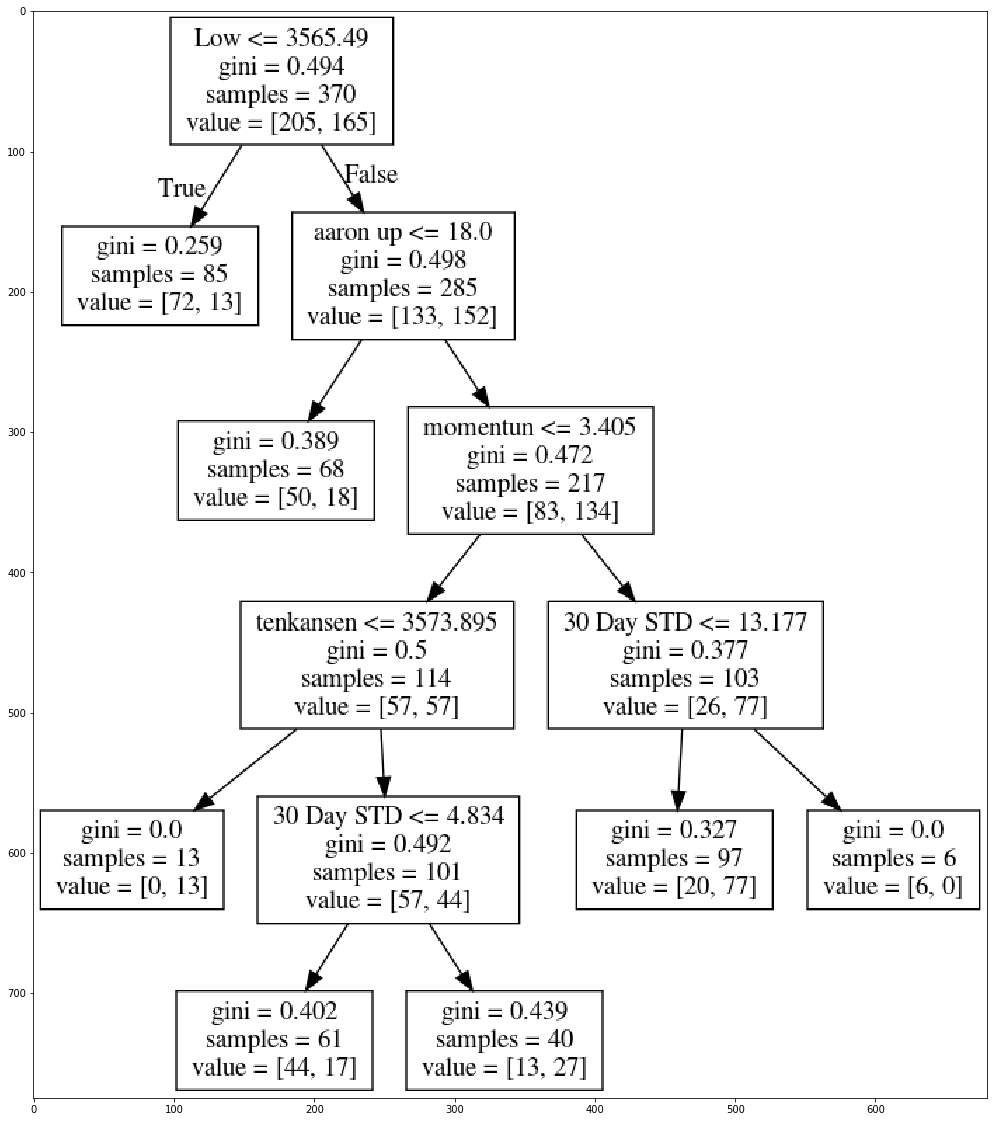

In [119]:
sig, acc = runStrategy()

In [ ]:
print('Primeiro sinal desse caralho dessa porra do demonho')
print(sig)
print('probabilidade de acerto')
print(round(acc, 2))

# Redes Neurais

## Todo

# Programação das rotinas do bot

In [ ]:
class Orders(object):
    def createOrder(self, side=SIDE_BUY, quantity=100, price='0.00001'):
        try:
            order = Client.create_test_order(
            symbol='USDTBTC',
            side=side,
            type=ORDER_TYPE_LIMIT,
            timeInForce=TIME_IN_FORCE_GTC,
            quantity=quantity,
            price=price)
        except:
            print('erro create order')
        
    def loginAPI(self):
        pass
    

class Bot(object):
    def __init__(self):
        self.botStatus = {
            'openOrder':'none',
            'lastOperation':'sell',
        }
    
    def checkStrategy(self):
        bb = Bbands()
        return bb.generateSignal()
    
    def checkSignal(self):
        signal = self.checkStrategy()
        if(signal == 'buy'):
            self.updateStatus('yes', signal)
        if (signal == 'sell'):
            self.updateStatus('no', signal)
        else:
            pass
    
    def updateStatus(self, status, operation):
        self.botStatus['openOrder'] = status
        self.botStatus['lastOperation'] = operation

In [ ]:
#main thread
from IPython.display import clear_output

aq.getCandles()
aq.plotCandles()

bot = Bot()
runtime = 0
while(True):
    bot.checkSignal()
    clear_output()
    print('Runtime = %s seconds' % (runtime))
    time.sleep(2)
    runtime += 2